# XGBoost回归模型
XGBoost是一种基于梯度提升（Gradient Boosting）的集成学习方法，通过组合多个弱学习器（通常是决策树）来提升预测性能。每棵新树都是在前一棵树的基础上，尝试减少模型的残差。

## 数据准备和库导入 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to testuate the model and return four metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Load training data
train_data = pd.read_csv('../datasets/train_data.csv')
test_data = pd.read_csv('../datasets/test_data.csv')

# Select the features and target
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
            'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 
            'YearBuilt', 'YearRemodAdd', 'Fireplaces']
X_train = train_data[features]
y_train = train_data['SalePrice']
X_test = test_data[features]
y_test = test_data['SalePrice']


## 实验一：直接调用xgboost库来实现xgboost回归


In [2]:
import xgboost as xgb
# 数据格式转换
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 设置参数
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',  #损失函数使用均方根误差
    'max_depth': 5,         # 树的深度
    'learning_rate': 0.05,  # 学习率
    'colsample_bytree': 0.3,# 每棵树训练时的特征采样比例
    'subsample': 0.7,       #每棵树训练时的子采样比例
    'lambda': 0.1,          # L2正则化
    'alpha': 0.1,           # L1正则化
}


# 记录评价指标
history = {
    'train': {'mae': [], 'mse': [], 'rmse': [], 'r2': []},
    'test': {'mae': [], 'mse': [], 'rmse': [], 'r2': []}
}


tests = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_boost_round=200, evals=tests, 
                  early_stopping_rounds=5, verbose_eval=10)
print('Best iteration:', model.best_iteration)

# 计算评价指标
print('caluculating metrics...')
for i in range(model.best_iteration):
    y_train_pred = model.predict(dtrain, iteration_range=(0, i+1))
    y_test_pred = model.predict(dtest, iteration_range=(0, i+1))

    # 计算训练集和验证集的MAE、MSE、RMSE、R2
    mae_train, mse_train, rmse_train, r2_train = evaluate_model(y_train, y_train_pred)
    mae_test, mse_test, rmse_test, r2_test = evaluate_model(y_test, y_test_pred)
    
    history['train']['mae'].append(mae_train)
    history['train']['mse'].append(mse_train)
    history['train']['rmse'].append(rmse_train)
    history['train']['r2'].append(r2_train)

    history['test']['mae'].append(mae_test)
    history['test']['mse'].append(mse_test)
    history['test']['rmse'].append(rmse_test)
    history['test']['r2'].append(r2_test)
print('model best metrics: MAE:', history['test']['mae'][-1], 'MSE',history['test']['mse'][-1], 'RMSE:', history['test']['rmse'][-1], 'R2:', history['test']['r2'][-1])
print('Training completed.')

[0]	train-rmse:75783.61418	test-rmse:78821.92728
[10]	train-rmse:53892.30155	test-rmse:58915.30540
[20]	train-rmse:39392.20355	test-rmse:45956.42581
[30]	train-rmse:31068.57338	test-rmse:39810.19774
[40]	train-rmse:26310.65580	test-rmse:36624.53964
[50]	train-rmse:23200.06045	test-rmse:34529.37564
[60]	train-rmse:21249.06543	test-rmse:33369.59935
[70]	train-rmse:19943.31038	test-rmse:32152.83147
[80]	train-rmse:18903.97468	test-rmse:31495.61000
[90]	train-rmse:18164.00031	test-rmse:31047.34621
[100]	train-rmse:17550.32888	test-rmse:30828.31637
[110]	train-rmse:17108.68809	test-rmse:30655.07118
[120]	train-rmse:16660.85098	test-rmse:30426.65770
[130]	train-rmse:16172.12654	test-rmse:30269.45916
[140]	train-rmse:15825.16322	test-rmse:30019.84749
[150]	train-rmse:15492.13662	test-rmse:29768.39765
[160]	train-rmse:15137.70278	test-rmse:29656.92248
[161]	train-rmse:15123.36338	test-rmse:29668.36683
Best iteration: 157
caluculating metrics...
model best metrics: MAE: 20465.836593000855 MSE 8

观察模型中不同决策变量的重要性

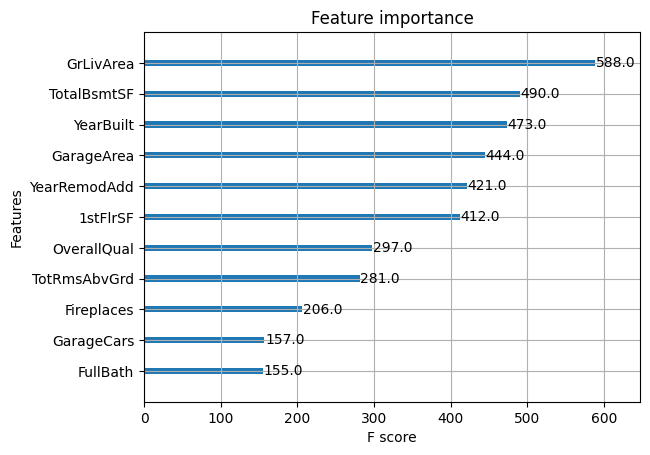

Important Features:
GrLivArea: 588.0
TotalBsmtSF: 490.0
YearBuilt: 473.0
GarageArea: 444.0
YearRemodAdd: 421.0
1stFlrSF: 412.0
OverallQual: 297.0
TotRmsAbvGrd: 281.0
Fireplaces: 206.0
GarageCars: 157.0
FullBath: 155.0


In [3]:
# Feature importance
xgb.plot_importance(model)
plt.show()
# Retrieve feature importance scores
importance_scores = model.get_score(importance_type='weight')

# Filter out unimportant features based on a score threshold
threshold = 0.2  # Define your threshold here
important_features = {feature: score for feature, score in importance_scores.items() if score >= threshold}

print("Important Features:")

for feature, score in sorted(important_features.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {score}")

展示训练结果

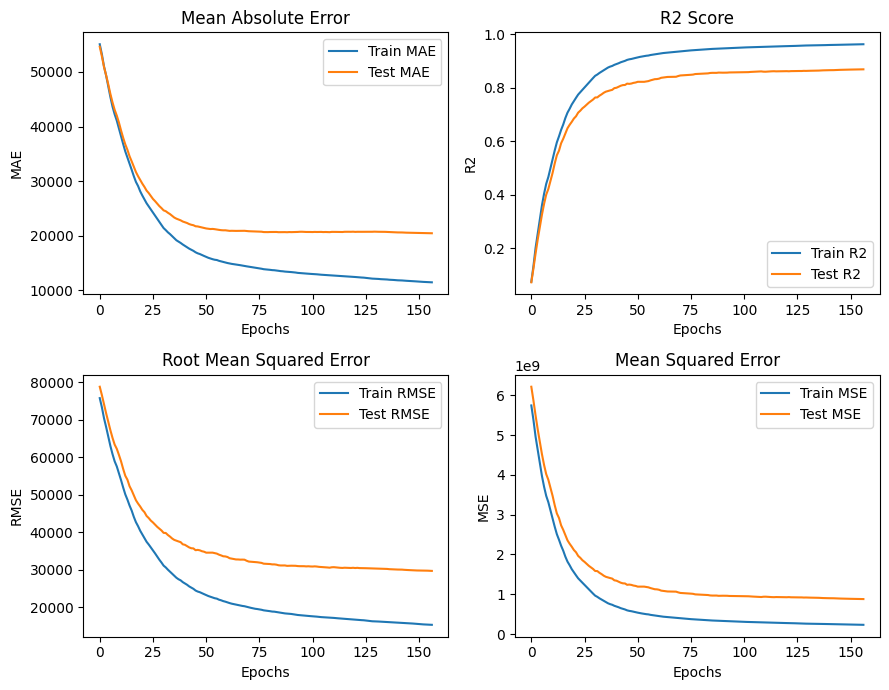

In [4]:
# Plot MAE
plt.figure(figsize=(9, 7))
epochs = len(history['train']['mae'])  # Ensure this is the number of actual training epochs
x_axis = range(epochs)
plt.subplot(2, 2, 1)
plt.plot(x_axis, history['train']['mae'], label='Train MAE')
plt.plot(x_axis, history['test']['mae'], label='Test MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot R2
plt.subplot(2, 2, 2)
plt.plot(x_axis, history['train']['r2'], label='Train R2')
plt.plot(x_axis, history['test']['r2'], label='Test R2')
plt.title('R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()

# Plot RMSE
plt.subplot(2, 2, 3)
plt.plot(x_axis, history['train']['rmse'], label='Train RMSE')
plt.plot(x_axis, history['test']['rmse'], label='Test RMSE')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot MSE
plt.subplot(2, 2, 4)
plt.plot(x_axis, history['train']['mse'], label='Train MSE')
plt.plot(x_axis, history['test']['mse'], label='Test MSE')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

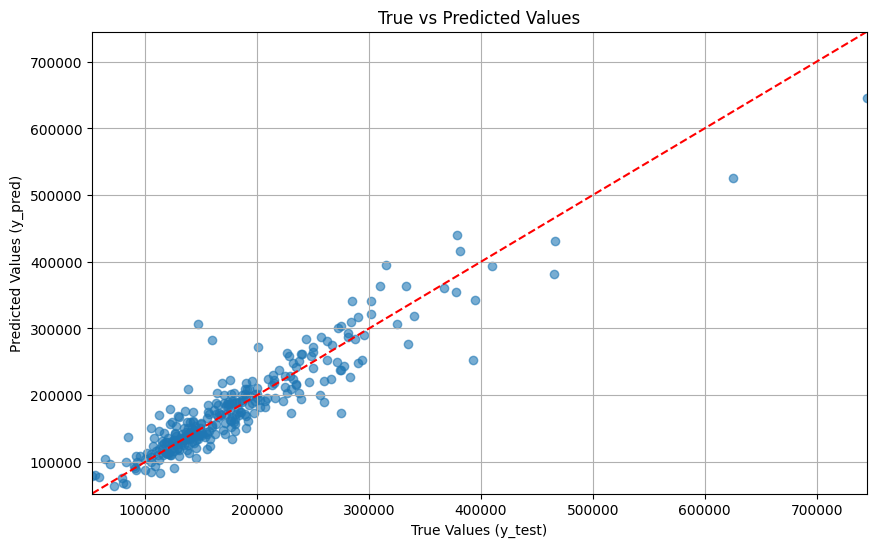

In [5]:
y_pred = model.predict(dtest, iteration_range=(0, model.best_iteration+1))
# 绘制真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title('True vs Predicted Values')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # 参考线
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()

可以看到结果基本上分布在红线附近，预测效果不错

## 实验二：观察不同超参数对模型训练的影响
学习率 (learning_rate)：低学习率可能需要更多轮次的训练，但通常表现较为稳定。较高的学习率会加速训练，但有时会导致模型过拟合。  
树的深度 (max_depth)：树越深，模型越复杂，但也可能会导致过拟合。适当的深度可以平衡模型的表达能力和泛化能力。  
特征子集大小(colsample_bytree)：控制每棵树训练时使用的特征子集大小。较小的值可以减少过拟合，但可能会损失一定的精度。  
正则化参数 lambda 和 alpha：用于控制模型的复杂度，增加正则化项可以减少过拟合，尤其是在数据较小或噪声较大的情况下。  

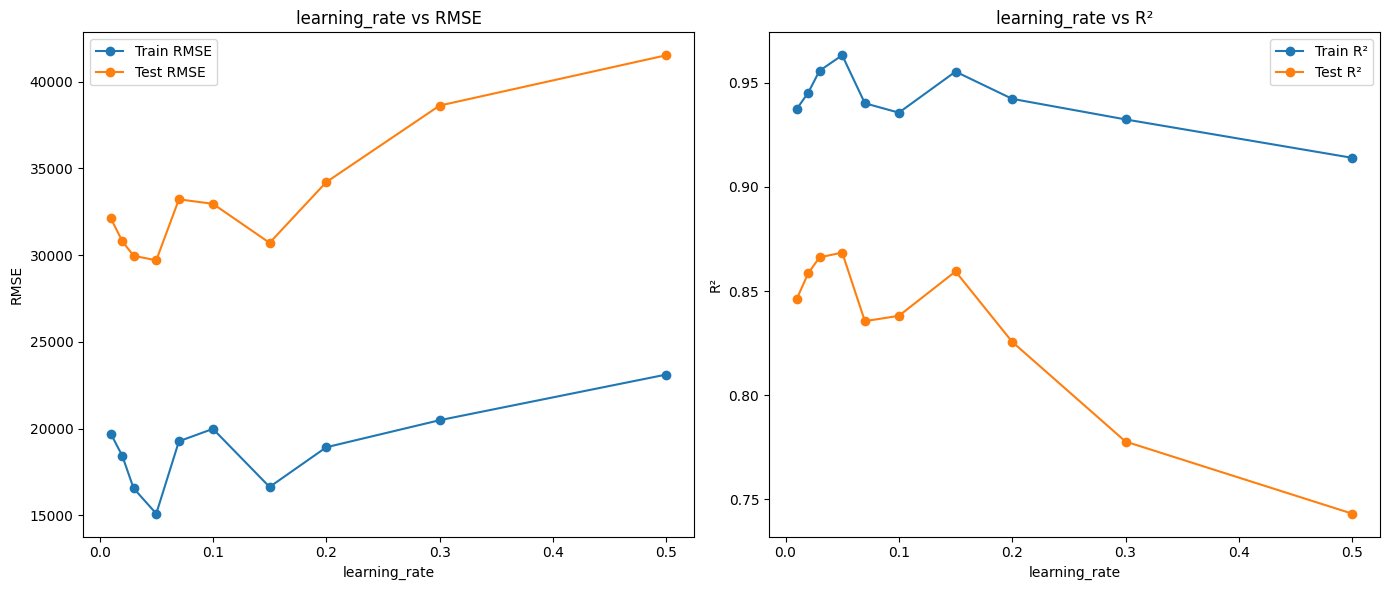

In [153]:
# 评价指标函数
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

# 基础模型参数
base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'learning_rate': 0.05,
    'colsample_bytree': 0.3,
    'subsample': 0.7,
    'lambda': 0.1,
    'alpha': 0.1
}

# 训练模型并返回 RMSE 和 R²
def train_and_evaluate(params, dtrain, dtest):
    evals = [(dtrain, 'train'), (dtest, 'test')]
    model = xgb.train(params, dtrain, num_boost_round=200, evals=evals, early_stopping_rounds=5, verbose_eval=False)
    
    # 预测测试集
    y_train_pred = model.predict(dtrain)
    y_test_pred = model.predict(dtest)
    
    # 计算 RMSE 和 R²
    rmse_train, r2_train = evaluate_model(y_train, y_train_pred)
    rmse_test, r2_test = evaluate_model(y_test, y_test_pred)
    
    return rmse_train, r2_train, rmse_test, r2_test

# 分别调整不同的超参数
def plot_param_variation(param_name, param_values, dtrain, dtest):
    train_rmse_list, test_rmse_list = [], []
    train_r2_list, test_r2_list = [], []

    for value in param_values:
        params = base_params.copy()
        params[param_name] = value

        # 训练模型并评估
        rmse_train, r2_train, rmse_test, r2_test = train_and_evaluate(params, dtrain, dtest)
        
        train_rmse_list.append(rmse_train)
        test_rmse_list.append(rmse_test)
        train_r2_list.append(r2_train)
        test_r2_list.append(r2_test)
    
    # 绘制 RMSE 变化图
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(param_values, train_rmse_list, label='Train RMSE', marker='o')
    plt.plot(param_values, test_rmse_list, label='Test RMSE', marker='o')
    plt.title(f'{param_name} vs RMSE')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend()

    # 绘制 R² 变化图
    plt.subplot(1, 2, 2)
    plt.plot(param_values, train_r2_list, label='Train R²', marker='o')
    plt.plot(param_values, test_r2_list, label='Test R²', marker='o')
    plt.title(f'{param_name} vs R²')
    plt.xlabel(param_name)
    plt.ylabel('R²')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 准备数据
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 1. 学习率 (learning_rate) 的变化
learning_rates = np.array([0.01, 0.02, 0.03, 0.05,  0.07, 0.1, 0.15, 0.20, 0.30, 0.50]) # 从 0.01 到 0.2 的 10 个值
plot_param_variation('learning_rate', learning_rates, dtrain, dtest)


**1.学习率变化：**  
在一定迭代次数情况下  
学习率过低，会导致模型训练时间长，模型效果未达到最优情况；  
学习率过高，则会导致模型过拟合。  
在该问题场景下，学习率在0.1左右是较为合适的选择  

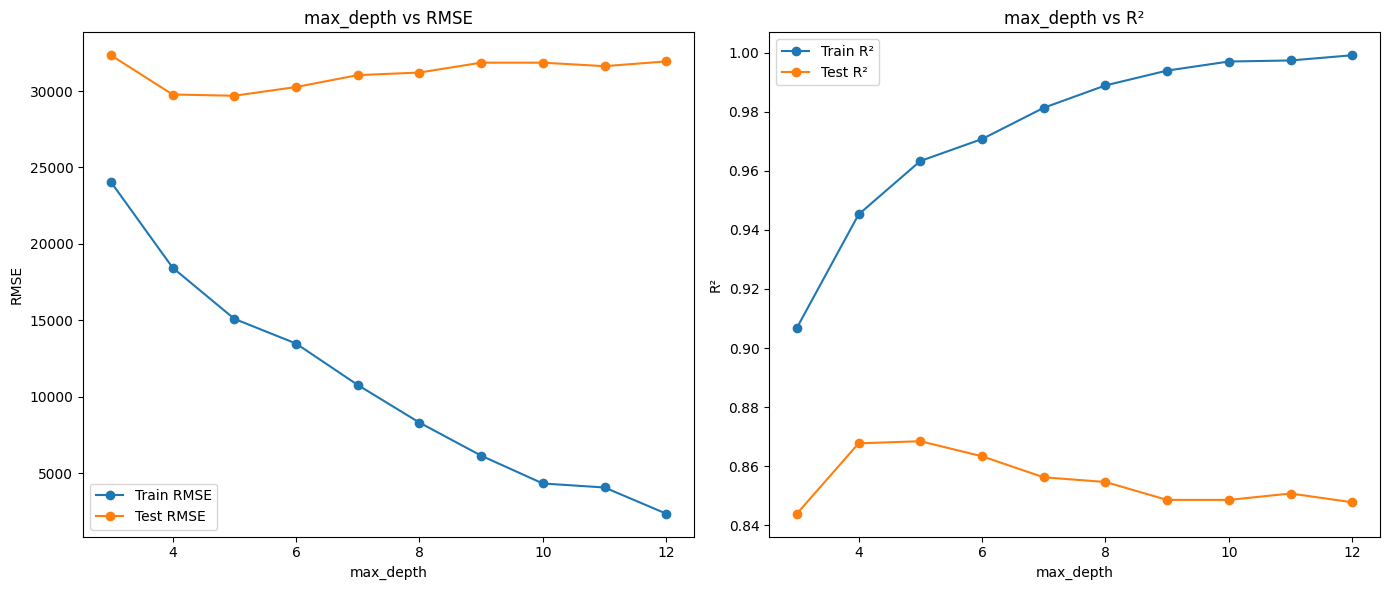

In [154]:
# 2. 树的深度 (max_depth) 的变化
max_depths = np.arange(3, 13)  # 从 3 到 12 的整数
plot_param_variation('max_depth', max_depths, dtrain, dtest)


**2.树的深度的变化：**  
随着树的深度的加深，训练集上的损失越来越小，R2越来越接近1  
但是测试集上的损失则先减后增，说明当深度较大时，模型过拟合  
在该问题场景下，树的深度选择4-6层较为合适

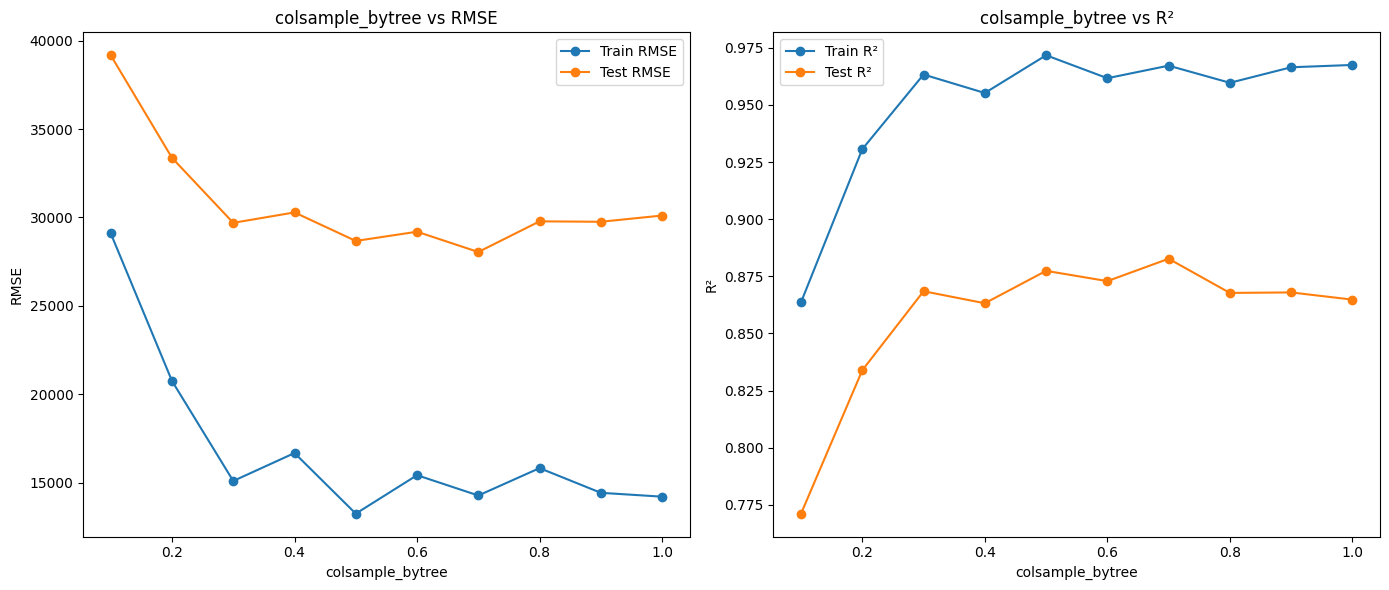

In [155]:
# 3. colsample_bytree 的变化
colsample_bytree_values = np.linspace(0.1, 1, 10)  # 从 0.1 到 1 的 10 个值
plot_param_variation('colsample_bytree', colsample_bytree_values, dtrain, dtest)


**3.特征子集比例的变化：**  
当特征子集增加到一定大小时，模型在训练集和测试集上的表现均趋于稳定  
但随着特征子集的增加，模型训练时间显著增长  
在该问题场景下，特征子集大小选择接近0.3(>0.3)时，模型效果最佳  

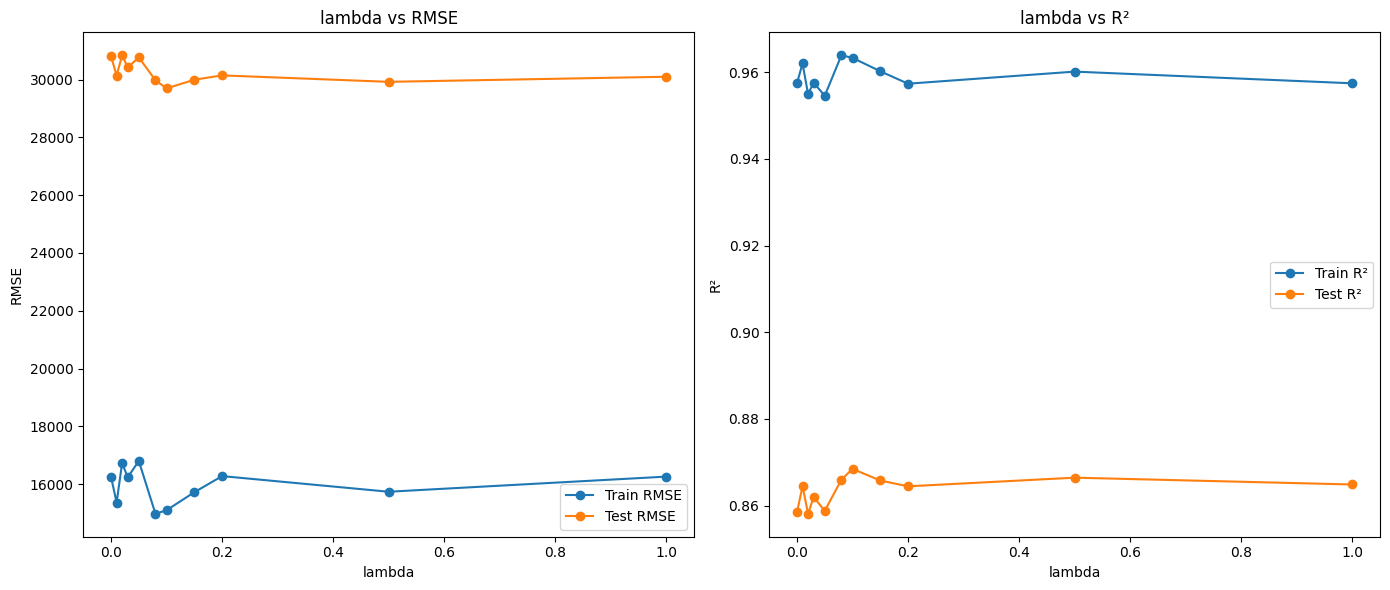

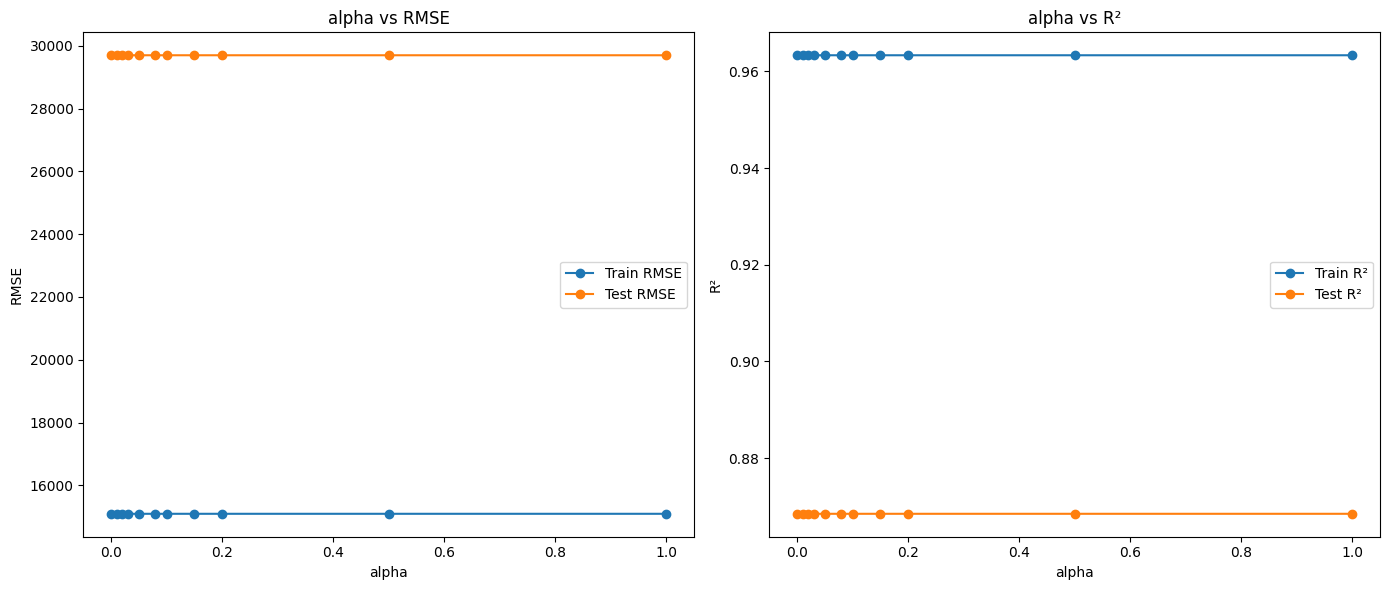

In [158]:
# 4. 正则化参数 lambda 的变化
lambda_values = np.array([0, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.5, 1])
plot_param_variation('lambda', lambda_values, dtrain, dtest)

# 5. 正则化参数 alpha 的变化
alpha_values = np.array([0, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.5, 1])
plot_param_variation('alpha', alpha_values, dtrain, dtest)

**4.正则化参数的变化：**  
L1正则化参数Lambda对模型的影响不大,适当大小的正则化系数对模型表现有一定的提示  
而L2正则化参数alpha则对模型几乎没有影响  
在该问题情境下，选择0.05左右的L1正则化系数有助于模型表现的提升  

## 实验三：手写XGBoost模型实现
具体搭建的步骤如下：  
1、初始化模型：  
首先，XGBoost 会计算初始预测值，通常为目标变量的平均值。这个预测值用于后续迭代的基准。  
2、迭代训练：  
在每一轮迭代中，XGBoost 会生成一棵新的决策树。新树的构建是基于前一棵树的预测结果与真实值之间的残差（即预测误差）。  
3、计算残差：  
计算每个样本的残差，它等于真实值与当前模型预测值之间的差   
4、构建新树：  
使用计算得到的残差作为目标，训练新的决策树。这棵树将尝试拟合这些残差，以减小下一轮的预测误差。  
5、更新预测：  
新树的输出会被加权并加到当前预测上，更新模型的预测值。  
$\hat{y}_i^{\text{new}} = \hat{y}_i^{\text{old}} + \eta \cdot f(x_i)$  
其中，η是学习率，f(x_i)是新树的预测结果.  
6、损失函数与正则化：  
XGBoost 通过最小化损失函数（例如均方误差）来评估模型的性能。正则化项被引入以控制模型复杂性，从而防止过拟合。  
7、迭代结束：  
该过程会持续进行，直到达到预设的迭代次数或模型性能不再显著提升。  
8、评价：  
在训练结束后，XGBoost 会根据指定的评估指标（例如 RMSE和R2）来评估模型的性能。

In [163]:
# 加载数据
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to testuate the model and return four metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Load training data
train_data = pd.read_csv('../datasets/train_data.csv')
test_data = pd.read_csv('../datasets/test_data.csv')

# Select the features and target
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
            'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 
            'YearBuilt', 'YearRemodAdd', 'Fireplaces']
X_train = train_data[features]
y_train = train_data['SalePrice']
X_test = test_data[features]
y_test = test_data['SalePrice']


Iteration 1: Train RMSE=78578.84714768486, Test RMSE=81793.09993392113, Train R²=0.005993305964265616, Test R²=0.0022082462582184714
Iteration 2: Train RMSE=79182.33447139079, Test RMSE=82500.39680548177, Train R²=-0.009333311074810391, Test R²=-0.015122955749118594
Iteration 3: Train RMSE=78311.85602287746, Test RMSE=81641.23794883894, Train R²=0.012736599079550825, Test R²=0.0059099269577937985
Iteration 4: Train RMSE=77171.39041098194, Test RMSE=80668.00847819143, Train R²=0.04128250288831459, Test R²=0.02946937367241531
Iteration 5: Train RMSE=73737.30922087906, Test RMSE=77187.41192236893, Train R²=0.12470877525271917, Test R²=0.11141386419216659
Iteration 6: Train RMSE=73821.90565327008, Test RMSE=77290.7009612922, Train R²=0.1226992364917674, Test R²=0.1090341337513906
Iteration 7: Train RMSE=68893.90433755591, Test RMSE=72677.58593347888, Train R²=0.23591865113731236, Test R²=0.21221526581658412
Iteration 8: Train RMSE=68907.0845251112, Test RMSE=72782.53291638228, Train R²=0.2

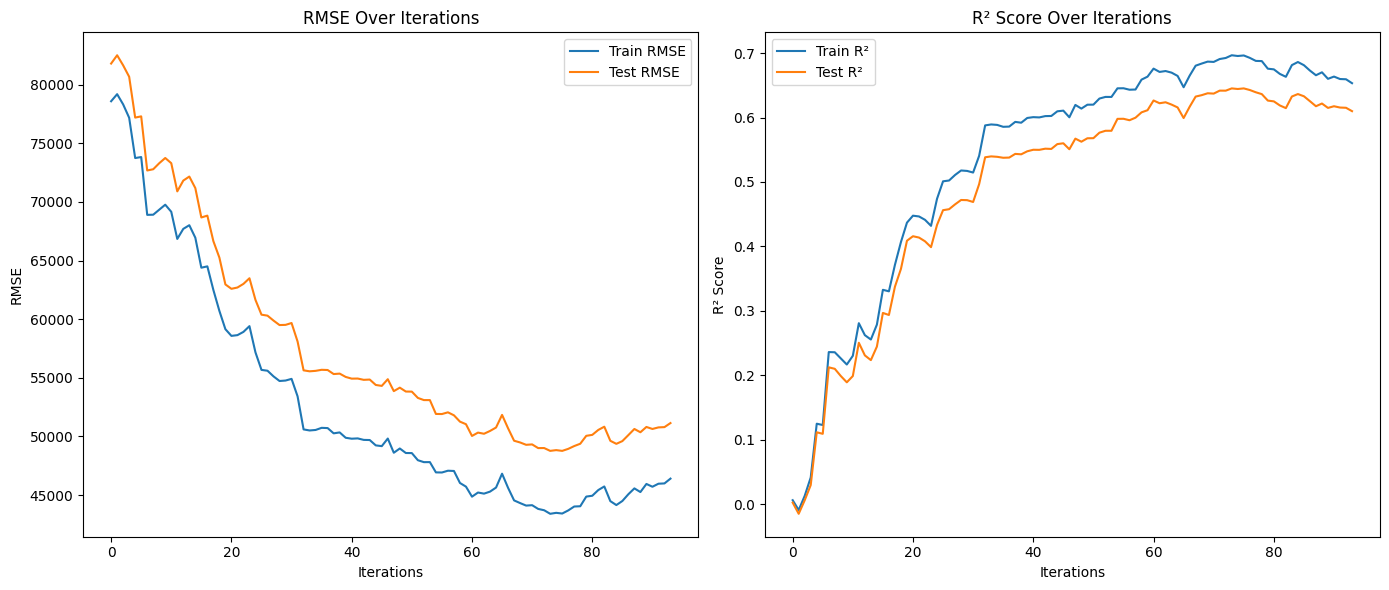

In [183]:
# 损失函数 RMSE 的计算
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# 构建单棵回归决策树
class DecisionTree:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        """
        递归构建决策树。
        
        - X: 特征矩阵
        - y: 目标变量
        - depth: 当前树的深度
        
        - 对于非叶子节点，返回一个元组 (feature_index, threshold, left_tree, right_tree)，
        其中 feature_index 是最佳划分特征的索引，threshold 是划分阈值，
        left_tree 和 right_tree 分别是左子树和右子树。
        - 对于叶子节点，返回目标变量的均值。
        """
        # 递归终止条件
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return np.mean(y)

        m, n = X.shape
        best_split = None
        best_loss = float('inf')

        for feature_index in range(n):
            # 遍历当前特征的所有唯一阈值
            for threshold in np.unique(X[:, feature_index]):
                # 根据阈值划分数据集
                left_indices = X[:, feature_index] < threshold
                right_indices = X[:, feature_index] >= threshold

                # 子节点为空，跳过当前划分
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                # 计算当前划分的损失
                loss = self._loss(y[left_indices], y[right_indices])
                # 更新最小损失和最佳划分
                if loss < best_loss:
                    best_loss = loss
                    best_split = (feature_index, threshold, left_indices, right_indices)

        # 如果没有找到最佳划分，则返回叶节点的均值
        if best_split is None:
            return np.mean(y)

        # 最佳划分信息
        feature_index, threshold, left_indices, right_indices = best_split
        # 递归构建左子树和右子树
        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        return (feature_index, threshold, left_tree, right_tree)

    def _loss(self, left_y, right_y):
        """
        计算左右两个子集的损失函数，该损失函数定义为两个子集的样本数与其方差的乘积之和。
        
        left_y: 左子集的标签值列表。
        right_y: 右子集的标签值列表。
        """
        return len(left_y) * np.var(left_y) + len(right_y) * np.var(right_y)

    def predict(self, X):
        return np.array([self._predict(sample, self.tree) for sample in X])
    
    def _predict(self, sample, tree):
        if not isinstance(tree, tuple):
            return tree  # 叶子节点的值
        feature_index, threshold, left_tree, right_tree = tree
        if sample[feature_index] < threshold:
            return self._predict(sample, left_tree)
        else:
            return self._predict(sample, right_tree)

# XGBoost 模型实现
class XGBoost:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 subsample=1, colsample_bytree=1,early_stopping_rounds=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.early_stopping_rounds = early_stopping_rounds
        self.trees = []
        self.train_rmse_history = []
        self.test_rmse_history = []
        self.train_r2_history = []
        self.test_r2_history = []
        self.best_iteration = None

    def fit(self, X_train, y_train, X_test, y_test):
        n_samples, n_features = X_train.shape
        self.base_pred = np.mean(y_train)  # 初始化预测值为均值
        y_train_pred = np.full(y_train.shape, self.base_pred)
        y_test_pred = np.full(y_test.shape, self.base_pred)
        
        best_rmse = float('inf')
        no_improvement_count = 0
        for i in range(self.n_estimators):
            # 计算残差
            residuals = y_train - y_train_pred

            # 构建回归树
            tree = DecisionTree(max_depth=self.max_depth)
            sampled_indices = np.random.choice(n_samples, int(self.subsample * n_samples), replace=False)
            feature_indices = np.random.choice(n_features, size=int(X_train.shape[1] * self.colsample_bytree), replace=False)
            tree.fit(X_train.values[sampled_indices][:, feature_indices], residuals[sampled_indices])
            
            # 更新预测值
            y_train_pred += self.learning_rate * tree.predict(X_train.values)
            y_test_pred += self.learning_rate * tree.predict(X_test.values)
            self.trees.append(tree)

            # 记录训练集和测试集的RMSE和R²
            train_rmse = rmse(y_train, y_train_pred)
            test_rmse = rmse(y_test, y_test_pred)
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            self.train_rmse_history.append(train_rmse)
            self.test_rmse_history.append(test_rmse)
            self.train_r2_history.append(train_r2)
            self.test_r2_history.append(test_r2)

            print(f"Iteration {i+1}: Train RMSE={train_rmse}, Test RMSE={test_rmse}, Train R²={train_r2}, Test R²={test_r2}")
            # 检查 RMSE 是否改善
            if test_rmse < best_rmse:
                best_rmse = test_rmse
                self.best_iteration = i
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # 检查是否达到提前停止条件
            if self.early_stopping_rounds and no_improvement_count >= self.early_stopping_rounds:
                print(f"Early stopping at iteration {i + 1}, best test RMSE: {best_rmse}")
                break
            
    def predict(self, X):
        y_pred = np.full(X.shape[0], self.base_pred)
        i=0
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
            i+=1
            if i>self.best_iteration:
                break
        return y_pred

    # 绘制 RMSE 和 R² 曲线
    def plot_metrics(self):
        # 绘制RMSE
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_rmse_history, label='Train RMSE')
        plt.plot(self.test_rmse_history, label='Test RMSE')
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title('RMSE Over Iterations')
        plt.legend()

        # 绘制R²
        plt.subplot(1, 2, 2)
        plt.plot(self.train_r2_history, label='Train R²')
        plt.plot(self.test_r2_history, label='Test R²')
        plt.xlabel('Iterations')
        plt.ylabel('R² Score')
        plt.title('R² Score Over Iterations')
        plt.legend()

        plt.tight_layout()
        plt.show()

# 使用RMSE和R2评估模型
from sklearn.metrics import r2_score

# 实例化XGBoost模型并训练
model = XGBoost(n_estimators=300, learning_rate=0.05, max_depth=6, colsample_bytree=0.4, subsample=0.7, early_stopping_rounds=20)
model.fit(X_train, y_train, X_test, y_test)

# 输出RMSE和R²
print(f'Train RMSE: {model.train_rmse_history[model.best_iteration]}, R²: {model.train_r2_history[model.best_iteration]}')
print(f'Test RMSE: {model.test_rmse_history[model.best_iteration]}, R²: {model.test_r2_history[model.best_iteration]}')

# 绘制训练过程中的RMSE和R²曲线
model.plot_metrics()


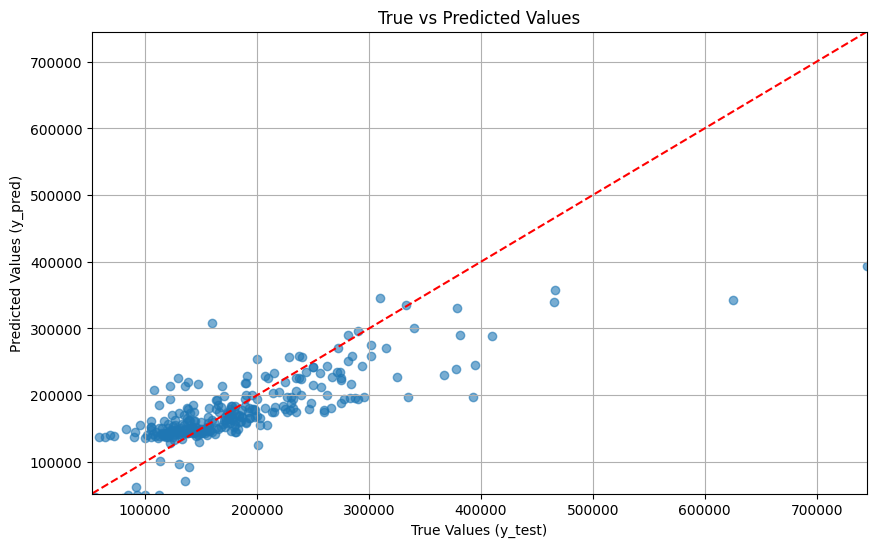

In [184]:
# 预测测试集的值
y_pred = model.predict(X_test.values)

# 绘制真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title('True vs Predicted Values')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # 参考线
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()

### 自实现模型评价：
可以发现，手写实现的算法也较好完成了预测，但是效果不如xgboost库的效果好。

原因可能有以下几点：  
**树的构建：**  
XGBoost 使用了高效的启发式算法（如贪婪算法）来构建树，并使用特定的分裂准则（如最小化均方误差），而自定义实现可能在选择最佳分裂点时存在差异。
正则化：XGBoost 的 L1 和 L2 正则化实现可能与自定义实现的方式不同，从而影响模型的复杂度和泛化能力。

**超参数设置：**  
XGBoost 库通常使用了一些默认超参数，这些参数经过优化以获得最佳性能。自定义实现可能没有进行相同的优化，或者在选择超参数时没有进行充分的调优。

**特征处理：**  
XGBoost 在处理缺失值和类别特征方面具有独特的策略，而自定义实现可能没有充分考虑这些方面。